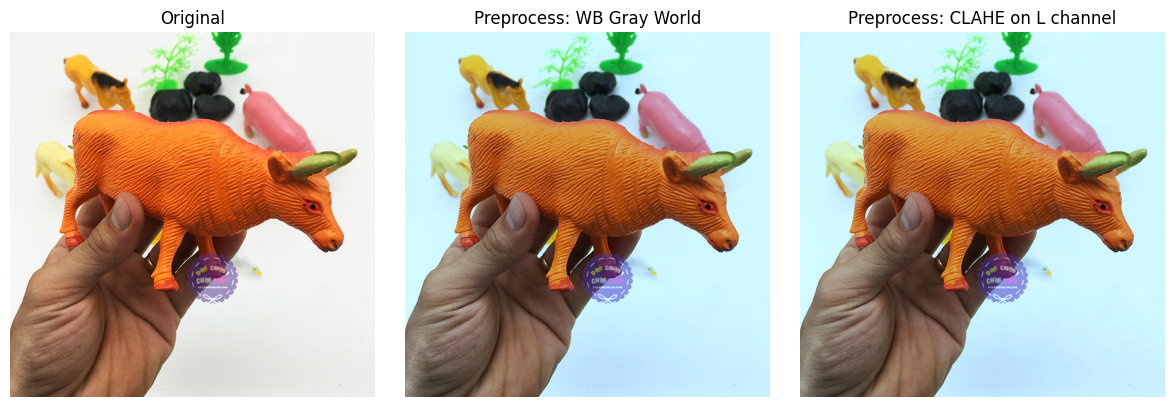

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


DEFAULT_CONFIG = {
    # in HSV, H has value from 0 -> 179, red color value have value from 0 -> 10 and 170 -> 179
    # so we need to split to red1 and red2 then combine their mask to detect full range of red
    "hsv": {
        "red1":  {"h":[0,10],   "s_min":60, "v_min":40},
        "red2":  {"h":[170,179],"s_min":60, "v_min":40},
        "orange":{"h":[10,20],  "s_min":55, "v_min":45},
        "yellow":{"h":[20,35],  "s_min":55, "v_min":50},
        "green": {"h":[35,85],  "s_min":50, "v_min":35},
        "cyan":  {"h":[85,95],  "s_min":45, "v_min":35},
        "blue":  {"h":[95,140], "s_min":50, "v_min":35},
        "purple":{"h":[140,160],"s_min":45, "v_min":35},
        "pink":  {"h":[160,170],"s_min":50, "v_min":40},
        "brown": {"h":[15,25],  "s_min":50, "v_max":120}
    },
    "lab_refs": {
        # L in 0..100, a,b around -128..+127
        "red":    {"L":54,"a":80,"b":67,"dE":18},
        "orange": {"L":75,"a":23,"b":78,"dE":16},
        "yellow": {"L":97,"a":-21,"b":94,"dE":16},
        "green":  {"L":87,"a":-86,"b":83,"dE":18},
        "cyan":   {"L":91,"a":-48,"b":-14,"dE":16},
        "blue":   {"L":32,"a":79,"b":-108,"dE":20},
        "purple": {"L":45,"a":75,"b":-36,"dE":18},
        "pink":   {"L":85,"a":51,"b":-4,"dE":18},
        "brown":  {"L":37,"a":15,"b":34,"dE":18}
    },
    "fusion": {"mode":"precise","w_hsv":0.4,"w_lab":0.6}
}

# ==== Color table cho vẽ khung/label (BGR) ====
COLOR_BGR_TABLE = {
    "red":    (0, 0, 255),
    "orange": (0, 128, 255),
    "yellow": (0, 225, 255),
    "green":  (0, 200, 0),
    "cyan":   (255, 255, 0),
    "blue":   (255, 0, 0),
    "purple": (200, 0, 200),
    "pink":   (203, 120, 255),
    "brown":  (19, 69, 139),
    "gray":   (128, 128, 128),
    "white":  (235, 235, 235),
    "black":  (10, 10, 10)
}

COLOR_SET_STD = ["red","orange","yellow","green","cyan","blue","purple","pink","brown"]


hsv_spec = DEFAULT_CONFIG.get("hsv", DEFAULT_CONFIG["hsv"])
lab_refs = DEFAULT_CONFIG.get("lab_refs", DEFAULT_CONFIG["lab_refs"])
fusion_cfg = DEFAULT_CONFIG.get("fusion", DEFAULT_CONFIG["fusion"])

# read image
img = cv2.imread('demo.jpg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# get 3 layers from image: blue, green, red
b, g, r = cv2.split(img.astype(np.float32))

# calculate mean of each layer
mb, mg, mr = b.mean(), g.mean(), r.mean()

# calculate k mean
k = (mb + mg + mr) / 3.0
# avoid divide by 0: if mean = 0, replace with a tiny value
mb = max(mb, 1e-6)
mg = max(mg, 1e-6)
mr = max(mr, 1e-6)

# calculate new pixel value for each layer
b = np.clip(b * (k/mb), 0, 255)
g = np.clip(g * (k/mg), 0, 255)
r = np.clip(r * (k/mr), 0, 255)

# combine 3 layers
img_gray_world = cv2.merge([b, g, r]).astype(np.uint8)
img_gray_world_rgb = cv2.cvtColor(img_gray_world, cv2.COLOR_BGR2RGB)
# convert BGR -> LAB: L: Lightness(độ sáng), A/B: thông tin màu
lab = cv2.cvtColor(img_gray_world, cv2.COLOR_BGR2LAB)

# split L, a, b from lab
L, a, b = cv2.split(lab)

clip = 2.0 # contrast limit, avoid increase too much
tiles = (8, 8) # split into window size 8x8 to do HE local

# create CLAHE object
clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tiles)

# Apply CLAHE to channel L only
L2 = clahe.apply(L)

# combine applied CLAHE L with a, b
lab2 = cv2.merge([L, a, b])

# Convert LAB to BGR
img_clahe = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
img_clahe_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)

# convert BGR to LAB
img_lab = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2LAB)
# convert BGR to HSV
img_hsv = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2HSV)

# get unique color names form lab_refs and hsv_spec (note: remove red1 and red2, only red)
names = set(lab_refs.keys())
for k in hsv_spec.keys():
    if k.startswith("red"):
        names.add("red")
    else:
        names.add(k)
color_names = sorted(names)

# get draw color which will use to annotate
draw_colors = COLOR_BGR_TABLE.copy()

def _in_range_hsv(hsv, h_range, s_min, v_min, v_max=255):
    # get 3 layers H S V from image
    H, S, V = cv2.split(hsv)
    # H range
    h1, h2 = h_range
    # condition if H value of image in H range from config
    cond_h = (H >= h1) & (H <= h2)
    # condition if S, V of image in S, V range from config
    cond_sv = (S.astype(np.int32) >= int(s_min)) & (V.astype(np.int32) >= int(v_min)) & (V.astype(np.int32) <= int(v_max))
    # return binary mask to indicate if color in image match with config range
    return (cond_h & cond_sv).astype(np.uint8) * 255

def hsv_mask(input_img_hsv, input_hsv_spec, color_name):
    if color_name == "red":
        m1 = _in_range_hsv(input_img_hsv, input_hsv_spec["red1"]["h"], input_hsv_spec["red1"]["s_min"], input_hsv_spec["red1"]["v_min"])
        m2 = _in_range_hsv(input_img_hsv, input_hsv_spec["red2"]["h"], input_hsv_spec["red2"]["s_min"], input_hsv_spec["red2"]["v_min"])
        return cv2.bitwise_or(m1, m2)
    else:
        st = hsv_spec[color_name]
        v_min = st.get("v_min", 0)
        v_max = st.get("v_max", 255)
        return _in_range_hsv(input_img_hsv, st["h"], st["s_min"], v_min, v_max)

# create empty masks
masks = {}
H, W = img_hsv.shape[:2]

for name in color_names:
    if name == "red":
        if "red1" in hsv_spec and "red2" in hsv_spec:
            m_hsv =





plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_gray_world_rgb)
plt.title("Preprocess: WB Gray World")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_clahe_rgb)
plt.title("Preprocess: CLAHE on L channel")
plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
DEFAULT_CONFIG = {
    "hsv": {
        "red1":  {"h":[0,10],   "s_min":60, "v_min":40},
        "red2":  {"h":[170,179],"s_min":60, "v_min":40},
        "orange":{"h":[10,20],  "s_min":55, "v_min":45},
        "yellow":{"h":[20,35],  "s_min":55, "v_min":50},
        "green": {"h":[35,85],  "s_min":50, "v_min":35},
        "cyan":  {"h":[85,95],  "s_min":45, "v_min":35},
        "blue":  {"h":[95,140], "s_min":50, "v_min":35},
        "purple":{"h":[140,160],"s_min":45, "v_min":35},
        "pink":  {"h":[160,170],"s_min":50, "v_min":40},
        "brown": {"h":[15,25],  "s_min":50, "v_max":120}
    },
    "lab_refs": {
        # L in 0..100, a,b around -128..+127
        "red":    {"L":54,"a":80,"b":67,"dE":18},
        "orange": {"L":75,"a":23,"b":78,"dE":16},
        "yellow": {"L":97,"a":-21,"b":94,"dE":16},
        "green":  {"L":87,"a":-86,"b":83,"dE":18},
        "cyan":   {"L":91,"a":-48,"b":-14,"dE":16},
        "blue":   {"L":32,"a":79,"b":-108,"dE":20},
        "purple": {"L":45,"a":75,"b":-36,"dE":18},
        "pink":   {"L":85,"a":51,"b":-4,"dE":18},
        "brown":  {"L":37,"a":15,"b":34,"dE":18}
    },
    "fusion": {"mode":"precise","w_hsv":0.4,"w_lab":0.6}
}

# ==== Color table cho vẽ khung/label (BGR) ====
COLOR_BGR_TABLE = {
    "red":    (0, 0, 255),
    "orange": (0, 128, 255),
    "yellow": (0, 225, 255),
    "green":  (0, 200, 0),
    "cyan":   (255, 255, 0),
    "blue":   (255, 0, 0),
    "purple": (200, 0, 200),
    "pink":   (203, 120, 255),
    "brown":  (19, 69, 139),
    "gray":   (128, 128, 128),
    "white":  (235, 235, 235),
    "black":  (10, 10, 10)
}

COLOR_SET_STD = ["red","orange","yellow","green","cyan","blue","purple","pink","brown"]


hsv_spec = DEFAULT_CONFIG.get("hsv", DEFAULT_CONFIG["hsv"])
lab_refs = DEFAULT_CONFIG.get("lab_refs", DEFAULT_CONFIG["lab_refs"])
fusion_cfg = DEFAULT_CONFIG.get("fusion", DEFAULT_CONFIG["fusion"])

print(hsv_spec)
print(lab_refs)
print(fusion_cfg)

names = set(lab_refs.keys())
print(names)
for k in hsv_spec.keys():
    if k.startswith("red"):
        names.add("red")
    else:
        names.add(k)
print(names)

draw_colors = COLOR_BGR_TABLE.copy()
print(draw_colors)

{'red1': {'h': [0, 10], 's_min': 60, 'v_min': 40}, 'red2': {'h': [170, 179], 's_min': 60, 'v_min': 40}, 'orange': {'h': [10, 20], 's_min': 55, 'v_min': 45}, 'yellow': {'h': [20, 35], 's_min': 55, 'v_min': 50}, 'green': {'h': [35, 85], 's_min': 50, 'v_min': 35}, 'cyan': {'h': [85, 95], 's_min': 45, 'v_min': 35}, 'blue': {'h': [95, 140], 's_min': 50, 'v_min': 35}, 'purple': {'h': [140, 160], 's_min': 45, 'v_min': 35}, 'pink': {'h': [160, 170], 's_min': 50, 'v_min': 40}, 'brown': {'h': [15, 25], 's_min': 50, 'v_max': 120}}
{'red': {'L': 54, 'a': 80, 'b': 67, 'dE': 18}, 'orange': {'L': 75, 'a': 23, 'b': 78, 'dE': 16}, 'yellow': {'L': 97, 'a': -21, 'b': 94, 'dE': 16}, 'green': {'L': 87, 'a': -86, 'b': 83, 'dE': 18}, 'cyan': {'L': 91, 'a': -48, 'b': -14, 'dE': 16}, 'blue': {'L': 32, 'a': 79, 'b': -108, 'dE': 20}, 'purple': {'L': 45, 'a': 75, 'b': -36, 'dE': 18}, 'pink': {'L': 85, 'a': 51, 'b': -4, 'dE': 18}, 'brown': {'L': 37, 'a': 15, 'b': 34, 'dE': 18}}
{'mode': 'precise', 'w_hsv': 0.4, 'w